In [1]:
%config Completer.use_jedi = False

In [2]:
import math
import random
import re

from jmetal.core.problem import PermutationProblem
from jmetal.core.solution import PermutationSolution

class VRP(PermutationProblem):
    

    def __init__(self, instance: str = None):
        super(VRP, self).__init__()

        distance_matrix, demand, number_of_cities, max_no_of_vehicle ,vehicle_capacity= self.__read_from_file(instance)

        self.distance_matrix = distance_matrix
        self.demand = demand
        self.max_no_of_vehicle = max_no_of_vehicle
        self.vehicle_capacity=vehicle_capacity
        self.number_of_objectives = 1
        self.obj_directions = [self.MINIMIZE]#,self.MINIMIZE]
        self.number_of_variables = number_of_cities
        self.obj_labels = ['no of vehicles', 'distance']
        self.number_of_constraints = 0
        self.test = 0

    def __read_from_file(self, filename: str):
        file=open(filename) 
        xcoordinate=[]
        ycoordinate=[]
        demand=[]
        while True:
            try:
                line=file.readline().split()
                if(line!=[]):
                    if((len(line)==2)&(line[0].isdigit())):
                        max_no_of_vehicle=int(line[0])              
                        vehicle_capacity=int(line[1])
                
                    elif((len(line)>=2)&(line[0].isdigit())):
                        xcoordinate.append(int(line[1]))
                        ycoordinate.append(int(line[2]))
                        demand.append(int(line[3]))
                if((xcoordinate!=[])&(len(line)==0)):
                            break
            except EOFError:
                pass
        file.close()
        #print(max_no_of_vehicle)
        #print(vehicle_capacity)
        #print(xcoordinate)
       # print(ycoordinate)
        #print(demand)
        dimension=len(demand)-1
       # print (dimension)
        matrix = [[-1] * (dimension+1) for _ in range(dimension+1)]
        for k in range(dimension+1):
            for j in range(dimension+1):
                dist = math.sqrt((xcoordinate[k]-xcoordinate[j]) ** 2 + (ycoordinate[k]-ycoordinate[j]) ** 2)
                dist = round(dist)
                matrix[k][j] = dist
        
        #print(matrix)

        return matrix,demand, dimension , max_no_of_vehicle,vehicle_capacity

    def evaluate(self, solution: PermutationSolution) -> PermutationSolution:
        fitness = 0
        nov=1
        perm=solution.variables
        crm=[0]
        cap=0
        dem=self.demand
        capacity=self.vehicle_capacity
        for i in perm:
            s=cap+dem[i+1]
            if(s <=capacity):
                crm.append(i+1)
                cap =s
            else:
                crm.append(0)
                nov+=1
                cap=0
                crm.append(i+1)
        crm.append(0)
        for i in range(len(crm)-1):
            x = crm[i]
            y = crm[i + 1]
            fitness += self.distance_matrix[x][y]
        solution.objectives[0] = fitness#nov
        #solution.objectives[1] =fitness
        return solution
    def get_route(self, solution: PermutationSolution) -> PermutationSolution:
        perm=solution.variables
        crm=[0]
        cap=0
        j=0
        dem=self.demand
        capacity=self.vehicle_capacity
        for i in perm:
            s=cap+dem[i+1]
            if(s <=capacity):
                crm.append(i+1)
                cap =s
            else:
                crm.append(0)
                
                cap=0
                crm.append(i+1)
        crm.append(0)
        for i in range(len(crm)-1):
            if(crm[i]==0):
                j=j+1
                print("route ",j,"->","Depot", end=' ')
                
            else:
                print("city",crm[i], end=' ')
                if(crm[i+1]==0):
                    print("Depot")
        return  
         

    def create_solution(self) -> PermutationSolution:
        new_solution = PermutationSolution(number_of_variables=self.number_of_variables,number_of_objectives=self.number_of_objectives)
        new_solution.variables = random.sample(range(self.number_of_variables), k=self.number_of_variables)
        #print(new_solution.variables)
        return new_solution


    def number_of_cities(self):
        return self.number_of_variables

    def get_name(self):
        return 'VRP'

In [12]:
from jmetal.algorithm.multiobjective.nsgaii import NSGAII
#from jmetal.algorithm.multiobjective.
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.util.termination_criterion import StoppingByEvaluations

problem = VRP('./Input.txt')
max_evaluations = 1000
algorithm = NSGAII(problem=problem,population_size=100,
                   offspring_population_size=100,
                   mutation=PermutationSwapMutation(0.1),
                   crossover=PMXCrossover(0.9),
                   termination_criterion=StoppingByEvaluations(max_evaluations)
)
algorithm.run()
solutions = algorithm.get_result()

In [13]:
distances = []
for sol in solutions:
    distances.append(sol.objectives[0])


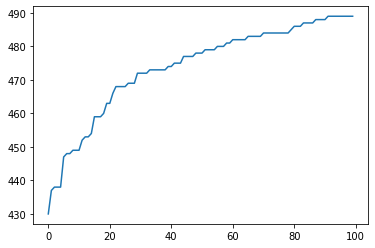

In [15]:

from jmetal.lab.visualization.plotting import Plot
from jmetal.util.solution import get_non_dominated_solutions
import matplotlib.pyplot as plt
front = get_non_dominated_solutions(solutions)

#plot_front = Plot('Pareto front approximation')#, axis_labels=[ 'Distance'])
#plot_front.plot(distances, label='NSGAII-VRP')
plt.plot(distances)

In [16]:
k = solutions[1]
k.objectives

[437]

In [18]:
for i in range(len(front)):
    #print("Solution" ,i+1,"no of vehicle=",front[i].objectives[0],"distance=",front[i].objectives[1])  
    problem.get_route(front[i])

route  1 -> Depot city 23 city 24 city 11 city 7 city 9 Depot
route  2 -> Depot city 12 city 15 city 13 Depot
route  3 -> Depot city 18 city 14 city 19 city 16 city 5 Depot
route  4 -> Depot city 1 city 6 city 4 city 2 city 3 Depot
route  5 -> Depot city 20 city 21 city 25 Depot
route  6 -> Depot city 22 city 8 city 17 city 10 Depot


In [18]:
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.operator import BinaryTournamentSelection
from jmetal.operator.crossover import PMXCrossover
from jmetal.operator.mutation import PermutationSwapMutation
from jmetal.problem.singleobjective.tsp import TSP
from jmetal.util.comparator import MultiComparator
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.termination_criterion import StoppingByEvaluations

if __name__ == '__main__':
    problem = TSP(instance='kroA100.tsp')

    print('Cities: ', problem.number_of_variables)

    algorithm = GeneticAlgorithm(
        problem=problem,
        population_size=100,
        offspring_population_size=100,
        mutation=PermutationSwapMutation(1.0 / problem.number_of_variables),
        crossover=PMXCrossover(0.8),
        selection=BinaryTournamentSelection(
            MultiComparator([FastNonDominatedRanking.get_comparator(),
                             CrowdingDistance.get_comparator()])),
        termination_criterion=StoppingByEvaluations(max_evaluations=25000)
    )

    algorithm.run()
    result = algorithm.get_result()
    
    print('Algorithm: {}'.format(algorithm.get_name()))
    print('Problem: {}'.format(problem.get_name()))
    print('Solution: {}'.format(result.variables))
    print('Fitness: {}'.format(result.objectives[0]))
    print('Computing time: {}'.format(algorithm.total_computing_time))

Cities:  100
Algorithm: Genetic algorithm
Problem: Symmetric TSP
Solution: [23, 25, 68, 60, 85, 54, 19, 56, 81, 94, 36, 12, 24, 37, 71, 31, 10, 5, 78, 93, 17, 15, 3, 87, 92, 61, 8, 72, 49, 4, 95, 77, 70, 38, 32, 51, 82, 2, 1, 16, 14, 98, 35, 28, 45, 42, 22, 90, 46, 18, 30, 55, 89, 62, 0, 84, 6, 97, 39, 53, 50, 13, 99, 40, 29, 80, 66, 57, 26, 86, 63, 33, 67, 43, 27, 75, 47, 34, 76, 69, 52, 48, 65, 21, 20, 9, 44, 58, 73, 83, 59, 11, 41, 96, 74, 64, 79, 88, 91, 7]
Fitness: 83338
Computing time: 5.068510055541992


In [2]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix

# 5 datapoints with 3 features
data = [[1, 0, 0],
        [1, 0.2, 0],
        [0, 0, 1],
        [0, 0, 0.9],
        [1, 0, 0.1]]

X = np.array(data)

distance_matrix(X,X)

centroid_idx = [0,2] # let data point 0 and 2 be our centroids
centroids = X[centroid_idx,:]
print(centroids) # [[1. 0. 0.]
                 # [0. 0. 1.]]

kmeans = KMeans(n_clusters=2, init=centroids, max_iter=1) # just run one k-Means iteration so that the centroids are not updated

kmeans.fit(X)
kmeans.labels_


[[1. 0. 0.]
 [0. 0. 1.]]


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


array([0, 0, 1, 1, 0], dtype=int32)